# Cochlear Receiver Tests

In [95]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path("..") / "src"))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig
from transmitter import SpikingRadarTransmitter
from receiver import ResonantCochlearReceiver


In [97]:
physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.5,  # Increased duration slightly to allow resonance to build
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.0,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
    receiver_spacing_m=0.2,
)

receiver = ResonantCochlearReceiver(
        config = model_config,
        n_channels = 32, # Number of neurons/resolution of cochlear
        f_start_hz = None, # Range of hearing, if none then defaults to config setup
        f_end_hz = None,  # Range of hearing, if none then defaults to config setup
        beta_slow = 0.99,  # Deprecated in new version, used to be for LIF of envelope detection
        w_in = 0.05,      # Very low input weight to ensure spiking is from resonance ONLY
        v_rest = 0.0,   # Equilibrium voltage
        v_thr = 1.0,     # Standard threshold voltage
        v_reset = 0.0,  # Resets to 0 voltage when spike occurs
        u_d = 0.1,      # Refractory period of output spikes
        damping = 0.01,  # Very low damping = High Selectivity (Sharp Peak)
    )
time_s = model_config.time_vector()

## Unit Test 1: Resonance Check

Driving Channel 10 at 1782.45 Hz...


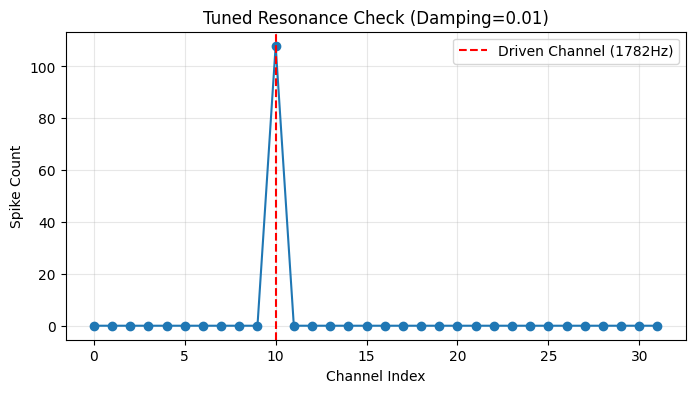

In [98]:
# Drive the channel-10 frequency with a pure tone
channel_idx = 10 
freq_hz = receiver.frequencies_hz[channel_idx]
print(f"Driving Channel {channel_idx} at {freq_hz:.2f} Hz...")

signal = np.sin(2.0 * np.pi * freq_hz * time_s)

# Run Process
spikes = receiver.process(signal, signal)
spike_counts = spikes["left"].sum(axis=1)

# --- 4. Plotting ---
plt.figure(figsize=(8, 4))
plt.plot(spike_counts, marker="o", linestyle='-')
plt.axvline(channel_idx, color="red", linestyle="--", label=f"Driven Channel ({freq_hz:.0f}Hz)")
plt.title(f"Tuned Resonance Check (Damping={receiver.damping})")
plt.xlabel("Channel Index")
plt.ylabel("Spike Count")
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()


Visualizing Physics:
1. Resonant Channel 10 (1782.4 Hz)
2. Dissonant Channel 15 (2379.7 Hz)


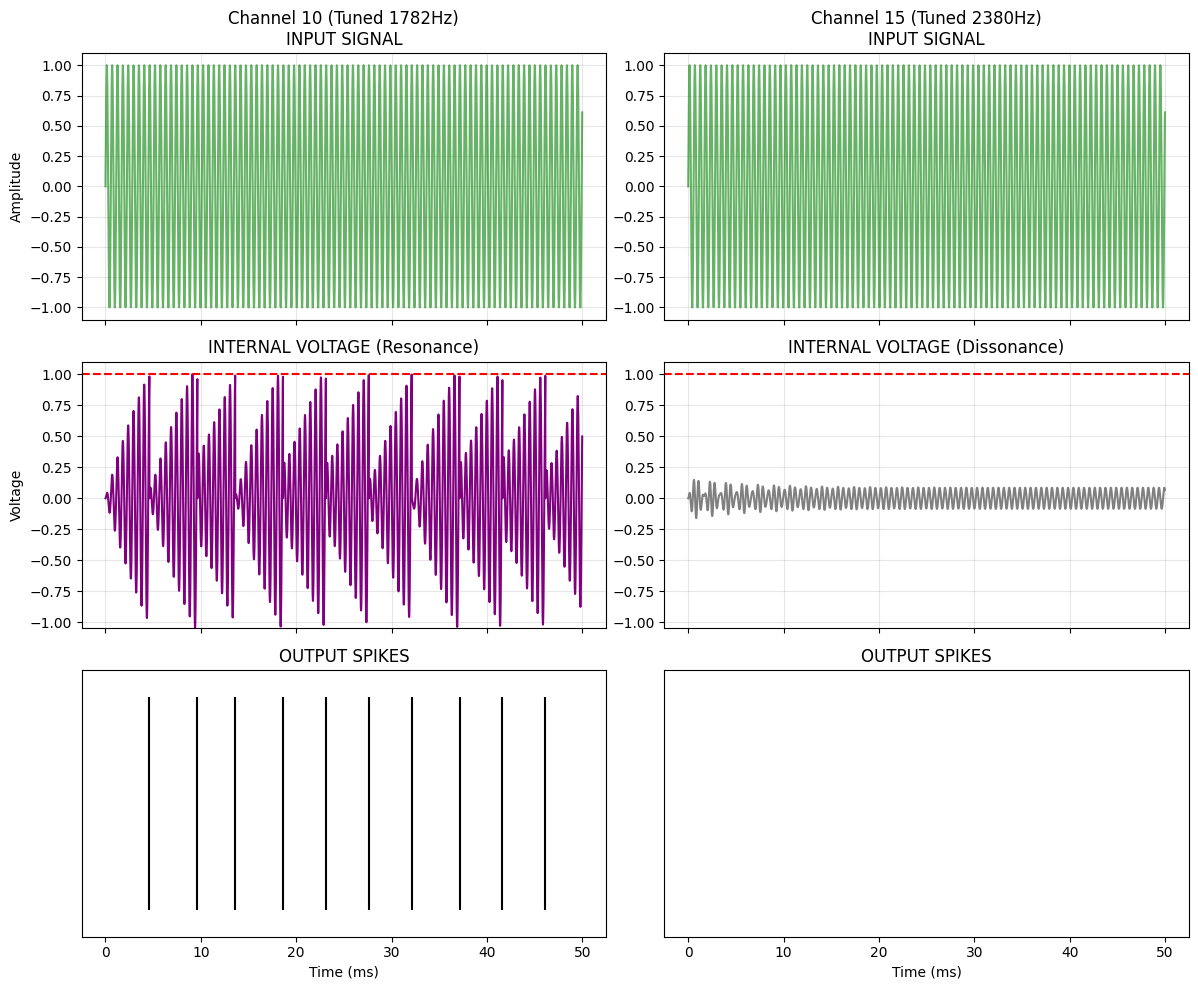

In [99]:
# --- 5. VISUALIZATION ADDITION: Input -> Voltage -> Spikes ---

# Select a second "Dissonant" channel (e.g., 5 indexes away)
dissonant_idx = (channel_idx + 5) % receiver.n_channels
freq_dissonant = receiver.frequencies_hz[dissonant_idx]

print(f"\nVisualizing Physics:")
print(f"1. Resonant Channel {channel_idx} ({freq_hz:.1f} Hz)")
print(f"2. Dissonant Channel {dissonant_idx} ({freq_dissonant:.1f} Hz)")

# Create a short visualization window (50ms)
viz_duration = 0.05
viz_time = np.arange(0, viz_duration, receiver.dt)
viz_signal = np.sin(2.0 * np.pi * freq_hz * viz_time) # The input sound

# Arrays to store traces
trace_res_v = np.zeros_like(viz_time)
trace_res_spikes = np.zeros_like(viz_time)
trace_dis_v = np.zeros_like(viz_time)
trace_dis_spikes = np.zeros_like(viz_time)

# Initialize states [v, u]
state_res = np.array([receiver.v_rest, 0.0]) 
state_dis = np.array([receiver.v_rest, 0.0]) 

# Params for manual simulation
params_res = {
    "A": receiver.A[channel_idx], "B": receiver.B[channel_idx], 
    "v_rest": receiver.v_rest, "input_gain": receiver.input_gain[channel_idx]
}
params_dis = {
    "A": receiver.A[dissonant_idx], "B": receiver.B[dissonant_idx], 
    "v_rest": receiver.v_rest, "input_gain": receiver.input_gain[dissonant_idx]
}

# --- Manual Physics Loop ---
for t in range(len(viz_time)):
    # 1. Resonant Channel
    I_res = viz_signal[t] * params_res["input_gain"]
    v_new = state_res[0] + receiver.dt * (params_res["A"] * (state_res[0] - params_res["v_rest"]) - state_res[1] + I_res)
    u_new = state_res[1] + receiver.dt * (params_res["B"] * (v_new - params_res["v_rest"]))
    
    if v_new >= receiver.v_thr:
        trace_res_spikes[t] = 1.0
        v_new = receiver.v_reset
        u_new += receiver.u_d
        
    state_res = [v_new, u_new]
    trace_res_v[t] = v_new

    # 2. Dissonant Channel
    I_dis = viz_signal[t] * params_dis["input_gain"]
    v_new_d = state_dis[0] + receiver.dt * (params_dis["A"] * (state_dis[0] - params_dis["v_rest"]) - state_dis[1] + I_dis)
    u_new_d = state_dis[1] + receiver.dt * (params_dis["B"] * (v_new_d - params_dis["v_rest"]))
    
    if v_new_d >= receiver.v_thr:
        trace_dis_spikes[t] = 1.0
        v_new_d = receiver.v_reset
        u_new_d += receiver.u_d
        
    state_dis = [v_new_d, u_new_d]
    trace_dis_v[t] = v_new_d

# --- Plotting the Stacked Comparison ---
# 3 Rows (Input, Voltage, Spikes), 2 Columns (Resonant, Dissonant)
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)

# --- COLUMN 1: RESONANT CHANNEL ---
# Row 0: Input Signal
axes[0, 0].plot(viz_time * 1000, viz_signal, color='green', alpha=0.6)
axes[0, 0].set_title(f"Channel {channel_idx} (Tuned {freq_hz:.0f}Hz)\nINPUT SIGNAL")
axes[0, 0].set_ylabel("Amplitude")
axes[0, 0].grid(True, alpha=0.3)

# Row 1: Voltage
axes[1, 0].plot(viz_time * 1000, trace_res_v, color='purple')
axes[1, 0].axhline(receiver.v_thr, color='red', linestyle='--', label='Thr')
axes[1, 0].set_title("INTERNAL VOLTAGE (Resonance)")
axes[1, 0].set_ylabel("Voltage")
axes[1, 0].grid(True, alpha=0.3)

# Row 2: Spikes
axes[2, 0].eventplot(np.where(trace_res_spikes > 0)[0] * receiver.dt * 1000, lineoffsets=0.5, linelengths=0.8, color='black')
axes[2, 0].set_title("OUTPUT SPIKES")
axes[2, 0].set_xlabel("Time (ms)")
axes[2, 0].set_yticks([]) # Hide Y axis numbers for spikes
axes[2, 0].set_ylim(0, 1)

# --- COLUMN 2: DISSONANT CHANNEL ---
# Row 0: Input Signal (Same input)
axes[0, 1].plot(viz_time * 1000, viz_signal, color='green', alpha=0.6)
axes[0, 1].set_title(f"Channel {dissonant_idx} (Tuned {freq_dissonant:.0f}Hz)\nINPUT SIGNAL")
axes[0, 1].grid(True, alpha=0.3)

# Row 1: Voltage
axes[1, 1].plot(viz_time * 1000, trace_dis_v, color='gray')
axes[1, 1].axhline(receiver.v_thr, color='red', linestyle='--', label='Thr')
axes[1, 1].set_title("INTERNAL VOLTAGE (Dissonance)")
axes[1, 1].grid(True, alpha=0.3)

# Row 2: Spikes
axes[2, 1].eventplot(np.where(trace_dis_spikes > 0)[0] * receiver.dt * 1000, lineoffsets=0.5, linelengths=0.8, color='black')
axes[2, 1].set_title("OUTPUT SPIKES")
axes[2, 1].set_xlabel("Time (ms)")
axes[2, 1].set_yticks([])
axes[2, 1].set_ylim(0, 1)

# Link Y-axes for Voltage to show true scale difference
y_min = min(np.min(trace_res_v), np.min(trace_dis_v), -0.1)
y_max = max(np.max(trace_res_v), np.max(trace_dis_v), receiver.v_thr) * 1.1
axes[1, 0].set_ylim(y_min, y_max)
axes[1, 1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Model Analysis: Resonant Cochlear Receiver

## 1. System Overview
This class implements a **neuromorphic auditory front-end**. It functions as a "Silicon Cochlea," breaking down an incoming audio signal into frequency channels not via Fourier Transform, but through physical resonance.

It utilizes a **Tonotopic Map** (logarithmically spaced frequencies) where each channel is a specific differential equation (a neuron) that vibrates sympathetically when the input signal matches its natural frequency.

---

## 2. Mathematical Derivation
The core of this model is the **Resonate-and-Fire (RF) Neuron**. Unlike standard "Integrate-and-Fire" neurons (which act like leaking buckets), this neuron acts like a **Damped Harmonic Oscillator** (a mass on a spring).

### The Differential Equations
The dynamics are governed by a system of two first-order coupled differential equations:

$$
\begin{aligned}
\frac{dv}{dt} &= A(v - v_{rest}) - u + I(t) \\
\frac{du}{dt} &= B(v - v_{rest})
\end{aligned}
$$

Where:
* $v$: Membrane potential (analogous to **Position** of the mass).
* $u$: Recovery variable (analogous to **Momentum** or restoring force).
* $I(t)$: The input current (the raw audio signal acting as a driving force).

### The Tuning Parameters ($A$ and $B$)
The code derives these parameters to enforce specific resonant properties:

1.  **Stiffness ($B$):** Determines the resonant frequency ($\omega$).
    $$B = \omega^2 = (2\pi f)^2$$
    * *Code:* `self.B = omega ** 2`

2.  **Damping ($A$):** Determines how long the neuron rings (the Q-factor).
    $$A = -2 \zeta \omega$$
    * *Code:* `self.A = -2.0 * damping * omega`
    * If $A$ is close to 0, the neuron rings forever. If $A$ is large negative, it stops instantly.

---

## 3. Process Flow Breakdown

### A. Initialization (`__init__`)
* **Logarithmic Spacing:** The code calculates `frequencies_hz` using `np.logspace`. This mimics the biological cochlea (Weber-Fechner law), placing more neurons at low frequencies and fewer at high frequencies, covering octaves rather than linear hertz.
* **Vectorized Parameters:** Arrays $A$ and $B$ are pre-calculated for all 32 channels, allowing the whole system to be updated in a single vector operation later.

### B. The "Ghost" Envelope (`_envelope_detector`)
* **Function:** Implements a low-pass filter (Leaky Integrator) to smooth the signal.
* **Status:** **Redundant.** In `_process_channel`, this method is called to create `env`, but `env` is never used. The raw `signal` is passed to the neuron instead.

### C. The Physics Engine (`_rf_neuron_step`)
This method performs the numerical integration of the differential equations.
* It calculates the derivatives `dv` and `du`.
* It updates the state variables $v$ and $u$.
* **Method Used:** **Forward Euler Integration**.
    $$v_{t+1} = v_t + \Delta t \cdot f(v_t, u_t)$$

### D. The Spike Logic (`_process_channel`)
1.  **Drive:** Feeds the raw `signal[t]` into the equations.
2.  **Threshold:** Checks `if v >= v_thr`.
3.  **Reset:** If a spike occurs:
    * Record spike (1.0).
    * Reset voltage $v \rightarrow v_{reset}$.
    * Bump recovery $u \rightarrow u + u_d$ (This creates a refractory period / self-inhibition).

---

## 4. Technical Critique & Stability Analysis

### Issue 1: Forward Euler Instability (Critical)
The code uses **Forward Euler** integration:
```python
return v + dv, u + du
```

## Unit Test 2: Chirp Response

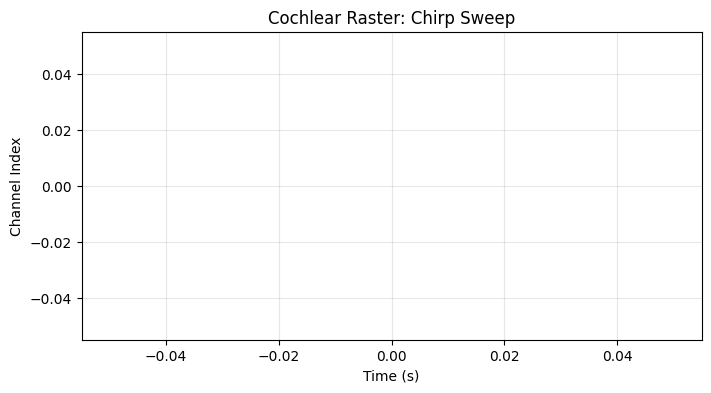

In [100]:
# Pass a modulated chirp through the cochlear receiver
transmitter = SpikingRadarTransmitter(model_config)
tx = transmitter.build()

spikes = receiver.process(tx.tx_signal, tx.tx_signal)
spike_matrix = spikes["left"]

spike_t = []
spike_i = []
for i in range(spike_matrix.shape[0]):
    times = np.flatnonzero(spike_matrix[i])
    spike_t.extend(time_s[times])
    spike_i.extend([i] * len(times))

plt.figure(figsize=(8, 4))
plt.scatter(spike_t, spike_i, s=2, color="black")
plt.title("Cochlear Raster: Chirp Sweep")
plt.xlabel("Time (s)")
plt.ylabel("Channel Index")
plt.grid(True, alpha=0.3)
plt.show()


## Unit Test 3: Binaural Comparison

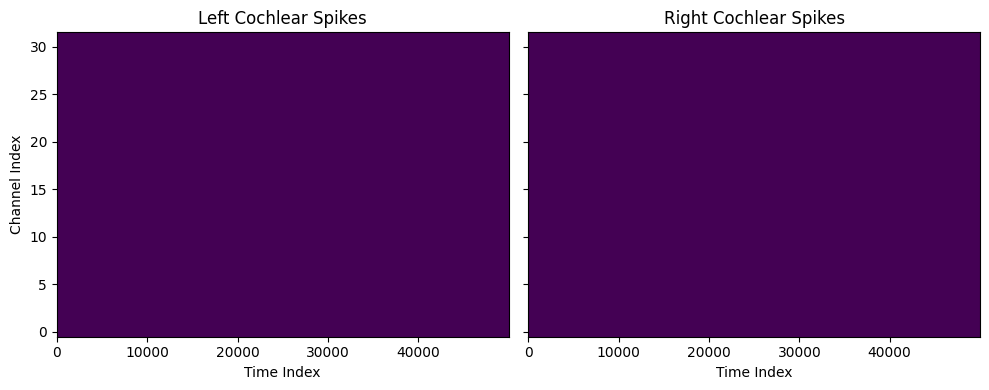

In [101]:
# Apply a small ITD/ILD and compare left/right spike matrices
itd_s = 200e-6
delay_samples = int(round(itd_s * model_config.fs_hz))

right = np.concatenate([np.zeros(delay_samples), tx.tx_signal[:-delay_samples]])
left = tx.tx_signal.copy()
right = 0.8 * right

spikes = receiver.process(left, right)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].imshow(spikes["left"], aspect="auto", origin="lower")
axes[0].set_title("Left Cochlear Spikes")
axes[0].set_xlabel("Time Index")
axes[0].set_ylabel("Channel Index")

axes[1].imshow(spikes["right"], aspect="auto", origin="lower")
axes[1].set_title("Right Cochlear Spikes")
axes[1].set_xlabel("Time Index")

plt.tight_layout()
plt.show()
